In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import keras_tuner as kt
tf.config.experimental.list_physical_devices('GPU')
import datetime

<h2>Extract MNIST data</h2>
<p style="font-size:20px">You can change the option of one_hot encoding.

In [2]:
#get mnist data, with one_hot encoding
mnist = tf.keras.datasets.mnist.load_data(path="mnist.npz")
(train_images, train_labels), (test_images, test_labels) = mnist
tl = train_labels
train_images = train_images.astype("float32")/255.0
test_images = test_images.astype("float32")/255.0
train_labels = tf.one_hot(train_labels,depth=10)
test_labels = tf.one_hot(test_labels, depth=10)

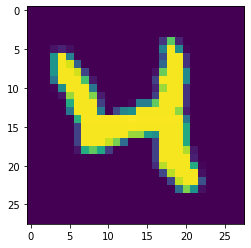

In [3]:
plt.figure()
plt.imshow(train_images[20])
plt.grid(False)
plt.show()

<h2>Define placeholder and Variables</h2>

In [4]:
def mnist_model(hp):
    """
    define model for hyper tune
    """
    activation = hp.Choice("activation", values=['relu', 'tanh', 'sigmoid'])

    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    for i in range(hp.Int("num_layers", 2, 6)):
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=16, max_value=256, step=16),
                activation=activation,
            )
        )
    model.add(keras.layers.Dense(10, activation="softmax"))
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1.0, 1e-2, 1e-3, 1e-4])),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    return model

<h2>Define tuner</h2>

In [5]:
tuner = kt.Hyperband(
    mnist_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='my_dir',
    project_name='minst_tuner_2'
)



stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

tuner.search_space_summary()

Search space summary
Default search space size: 5
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 1.0, 'conditions': [], 'values': [1.0, 0.01, 0.001, 0.0001], 'ordered': True}


In [6]:
#START TUNING
tuner.search(train_images, train_labels, epochs=10, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 32s]
val_accuracy: 0.9375

Best val_accuracy So Far: 0.9725833535194397
Total elapsed time: 00h 08m 24s
INFO:tensorflow:Oracle triggered exit


<h2>Execute training</h2>

In [7]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="/my_dir/mnist_logs")
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_images,
                    train_labels,
                    batch_size=64,
                    epochs=20,
                    validation_data=(test_images, test_labels),
                    callbacks=[tb_callback])

Epoch 1/20
938/938 [==============================] - 4s 4ms/step - loss: 0.2540 - accuracy: 0.9241 - val_loss: 0.1199 - val_accuracy: 0.9634
Epoch 2/20
938/938 [==============================] - 3s 3ms/step - loss: 0.1028 - accuracy: 0.9683 - val_loss: 0.1140 - val_accuracy: 0.9641
Epoch 3/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0736 - accuracy: 0.9769 - val_loss: 0.0806 - val_accuracy: 0.9769
Epoch 4/20
938/938 [==============================] - 3s 3ms/step - loss: 0.0555 - accuracy: 0.9827 - val_loss: 0.0805 - val_accuracy: 0.9758
Epoch 5/20
938/938 [==============================] - 2s 3ms/step - loss: 0.0480 - accuracy: 0.9850 - val_loss: 0.0986 - val_accuracy: 0.9730
Epoch 6/20
938/938 [==============================] - 2s 3ms/step - loss: 0.0404 - accuracy: 0.9868 - val_loss: 0.0810 - val_accuracy: 0.9773
Epoch 7/20
938/938 [==============================] - 2s 2ms/step - loss: 0.0329 - accuracy: 0.9895 - val_loss: 0.0854 - val_accuracy: 0.9774
Epoch 

<h2>Your results</h2>

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 0, 'epoch')

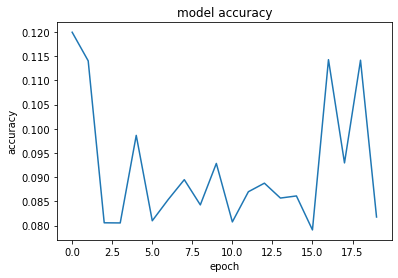

In [8]:
print(history.history.keys())
plt.plot(history.history["val_loss"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [9]:
acc=model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.0818 - accuracy: 0.9798


In [10]:
tuner.oracle.get_best_trials()[0].trial_id
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 176)               138160    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                11328     
_________________________________________________________________
dense_5 (Dense)              (None, 160)               10400     
_________________________________________________________________
dense_6 (Dense)              (None, 144)               23184     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1450      
Total params: 184,522
Trainable params: 184,522
Non-trainable params: 0
________________________________________________

In [11]:
tuner.results_summary()

Results summary
Results in my_dir\minst_tuner_2
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
activation: relu
num_layers: 4
units_0: 176
units_1: 64
learning_rate: 0.001
units_2: 160
units_3: 144
units_4: 80
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: de71c00704d547f96bce28d91b8fd676
Score: 0.9725833535194397
Trial summary
Hyperparameters:
activation: relu
num_layers: 5
units_0: 208
units_1: 144
learning_rate: 0.001
units_2: 256
units_3: 224
units_4: 176
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 11a2cedf313590558ca242cde18c15c9
Score: 0.9721666574478149
Trial summary
Hyperparameters:
activation: relu
num_layers: 4
units_0: 176
units_1: 64
learning_rate: 0.001
units_2: 160
units_3: 144
units_4: 80
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.9704166650772095
Trial summary
Hyperparameters:
activation: tanh
nu

In [12]:
tf.keras

<module 'tensorflow.keras' from 'C:\\Users\\alber\\anaconda3\\envs\\tf-gpu\\lib\\site-packages\\keras\\api\\_v2\\keras\\__init__.py'>